# Assignment 2.2 - Occupancy Grid Construction

### Importing necessary libraries

In [16]:
import sys
import numpy as np
import open3d as o3d
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import IPython
from PIL import Image
# sys.path.insert(1, "../dataset")
sys.path.insert(1, "../Assignment_2.1")
from A21 import computePoseCameraFrame

### Step by step explanation of the process for a single bin file (Just for explanation, the whole code has been modularised below)

#### Read 0000000.bin using functions from 2.1, store the point cloud and round off the scan's x,y,z readings for discretization. Output is the rounded off pcd printed as a numpy array.

In [18]:
poses = computePoseCameraFrame(0)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(poses[:,:3])
# print (np.asarray(pcd.points))
# o3d.visualization.draw_geometries([pcd])
pcd1 = np.round(np.asarray(pcd.points))
print (pcd1)

[[ -6.  -2.  52.]
 [-13.  -3.  79.]
 [-13.  -3.  79.]
 ...
 [  1.   2.   4.]
 [  1.   2.   4.]
 [  1.   2.   4.]]


#### Converting the scans into a Pandas dataframe, dropping duplicate rows and grouping by x,z to create all pairs of (x,z). Output displays the count of distinct y readings for every (x,z) pair

In [3]:
pcd_df = pd.DataFrame(data=pcd1,columns=['x','y','z'])
pcd_df.drop_duplicates(subset = ["y","x","z"],inplace=True)
pts = pcd_df.groupby(['x','z']).count().index
counts = pcd_df.groupby(['x','z']).count()
print (counts)

             y
x     z       
-74.0  30.0  1
-72.0 -36.0  1
      -34.0  5
      -33.0  1
-71.0 -38.0  1
...         ..
 73.0  23.0  2
       24.0  1
 74.0  17.0  1
       23.0  2
 75.0  23.0  1

[5894 rows x 1 columns]


#### Creating a new Pandas dataframe with only the information relevant to us. It has two columns: "pts" indicates the (x,z) pair and "count" indicates the count of distinct y value for each pair

In [20]:
pcd_new = pd.DataFrame({'pts':pts.values,'count':counts['y']})
pcd_new.reset_index(drop=True,inplace=True)
pcd_new

,pts,count
0,"(-74.0, 30.0)",1
1,"(-72.0, -36.0)",1
2,"(-72.0, -34.0)",5
3,"(-72.0, -33.0)",1
4,"(-71.0, -38.0)",1
...,...,...
5889,"(73.0, 23.0)",2
5890,"(73.0, 24.0)",1
5891,"(74.0, 17.0)",1
5892,"(74.0, 23.0)",2


#### To decide threshold for creating the occupancy grid, we display the statistics for our new dataframe, noting the mean and the standard deviation of the count 

In [6]:
pcd_new[['count']].describe()

,count
count,5894.000000
mean,1.436206
std,0.939500
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,7.000000


#### Storing the (x,z) pairs (which will become our points in the occupancy grid) into an array

In [23]:
pts_array = pcd_new['pts'].values

#### Creating an empty 200*200 array and marking points (basically the (x,z) pairs) where the count of y exceeds a certain threshold (in this case >1)

In [24]:
img = np.zeros((200,200,1), np.uint8)
for i in range(len(pts_array)):
    ind = (pts_array[i][0] + 100,pts_array[i][1]+ 100)
    county = pcd_new.iloc[i,1]
    if (county>1):
#         print ("I am probably an obstacle!")
        img[int(ind[0])][int(ind[1])] = 1

#### Visualising the resultant occupancy grid for 0000000.bin, and saving it as grid.png

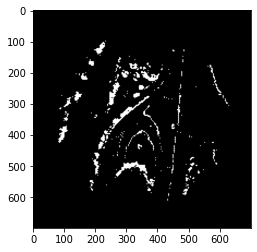

In [25]:
img = cv.resize(img,(700,700))
im = cv.imwrite('grid.png',img*255)
imip = cv.imread('grid.png')
plt.imshow(imip)

### Modularising the concept explained so far...

#### Function to compute occupancy grid for an individual pcd. 
`Input`: pcd (an individual point cloud (or a net_pcd resulting from addition of multiple pcds)

`Output`: An 400*400 array representing the image of the occupancy grid

`Usage`: img = computeGrid_individual_pcd(individual_pcd)

In [11]:
def computeGrid_individual_pcd(pcd):
    pcd1 = np.round(np.asarray(pcd.points))
    pcd_df = pd.DataFrame(data=pcd1,columns=['x','y','z'])
    pcd_df.drop_duplicates(subset = ["y","x","z"],inplace=True)
    pts = pcd_df.groupby(['x','z']).count().index
    counts = pcd_df.groupby(['x','z']).count()
    pcd_new = pd.DataFrame({'pts':pts.values,'count':counts['y']})
    pcd_new.reset_index(drop=True,inplace=True)
    pts_array = pcd_new['pts'].values
    img = np.zeros((400,400,1), np.uint8)
    for j in range(len(pts_array)):
        ind = (pts_array[j][0] + 200,pts_array[j][1]+ 200)
        county = pcd_new.iloc[j,1]
        if (county>2):
    #         print ("I am probably an obstacle!")
            img[int(ind[0])][int(ind[1])] = 1
    return img

#### Function to compute occupancy grid of a LIDAR bin file indicated by a certain index
`Input`: the index of the LIDAR bin file to read and process for creation of occupancy grid

`Output`: An 400*400 array representing the image of the occupancy grid

`Usage`: img = computeGrid(index_of_bin_file)

In [12]:
def computeGrid(i):
    poses = computePoseCameraFrame(i)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(poses[:,:3])
    pcd1 = np.round(np.asarray(pcd.points))
    pcd_df = pd.DataFrame(data=pcd1,columns=['x','y','z'])
    pcd_df.drop_duplicates(subset = ["y","x","z"],inplace=True)
    pts = pcd_df.groupby(['x','z']).count().index
    counts = pcd_df.groupby(['x','z']).count()
    pcd_new = pd.DataFrame({'pts':pts.values,'count':counts['y']})
    pcd_new.reset_index(drop=True,inplace=True)
    pts_array = pcd_new['pts'].values
    img = np.zeros((400,400,1), np.uint8)
    for j in range(len(pts_array)):
        ind = (pts_array[j][0] + 200,pts_array[j][1]+ 200)
        county = pcd_new.iloc[j,1]
        if (county>1):
    #         print ("I am probably an obstacle!")
            img[int(ind[0])][int(ind[1])] = 1
    return img

### Part a) Create an occupancy grid map for each LiDAR scan. For the purpose of this assignment, you do not need to apply bayesian update rules and each individual scan can be assumed as a prior. Save each scan as a binary png

#### Generating occupancy grid for each of 77 LIDAR bin files and saving them under `data/imgs/cv/`. Occupancy grid for 0000000.bin corresponds to grid0.png, that of 0000001.bin corresponds to grid1.png and so on.

In [29]:
for i in range(77):
    img = computeGrid(i)
    img = cv.resize(img,(700,700))
    filename = '../data/imgs/cv/grid'+str(i)+'.png'
    im = cv.imwrite(filename,img*255)

### Part b) Using odometry data, concat multiple scans and create a occupancy grid of 5, 10 and 15 scans

#### Concat the first 5 LIDAR bin files from 0000000.bin to 0000004.bin using `computePoseCameraFrame()` from 2.1 and displaying the occupancy grid of the net pcd. 

#### The occupancy grid generated is saved as `grid_for_5.png` under `data/imgs/cv/`

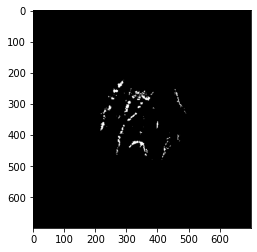

In [13]:
pcd_net = o3d.geometry.PointCloud()
for i in range(5):
    poses = computePoseCameraFrame(i)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(poses[:,:3])
    pcd_net += pcd
# downpcd = pcd_net.voxel_down_sample(voxel_size=1)
# o3d.visualization.draw_geometries([downpcd])
img_5 = computeGrid_individual_pcd(pcd_net)
img_5 = cv.resize(img_5,(700,700))
filename = '../data/imgs/cv/grid_for_5.png'
im = cv.imwrite(filename,img_5*255)
imip = cv.imread('../data/imgs/cv/grid_for_5.png')
plt.imshow(imip)

#### Concat the first 10 LIDAR bin files from 0000000.bin to 0000009.bin using `computePoseCameraFrame()` from 2.1 and displaying the occupancy grid of the net pcd. 

#### The occupancy grid generated is saved as `grid_for_10.png` under `data/imgs/cv/`

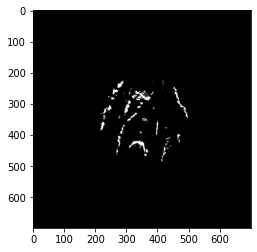

In [14]:
pcd_net = o3d.geometry.PointCloud()
for i in range(10):
    poses = computePoseCameraFrame(i)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(poses[:,:3])
    pcd_net += pcd
# downpcd = pcd_net.voxel_down_sample(voxel_size=1)
# o3d.visualization.draw_geometries([downpcd])
img_5 = computeGrid_individual_pcd(pcd_net)
img_5 = cv.resize(img_5,(700,700))
filename = '../data/imgs/cv/grid_for_10.png'
im = cv.imwrite(filename,img_5*255)
imip = cv.imread('../data/imgs/cv/grid_for_10.png')
plt.imshow(imip)

#### Concat the first 15 LIDAR bin files from 0000000.bin to 0000014.bin using `computePoseCameraFrame()` from 2.1 and displaying the occupancy grid of the net pcd. 

#### The occupancy grid generated is saved as `grid_for_15.png` under `data/imgs/cv/`

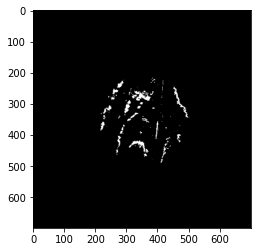

In [15]:
pcd_net = o3d.geometry.PointCloud()
for i in range(15):
    poses = computePoseCameraFrame(i)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(poses[:,:3])
    pcd_net += pcd
# downpcd = pcd_net.voxel_down_sample(voxel_size=1)
# o3d.visualization.draw_geometries([downpcd])
img_5 = computeGrid_individual_pcd(pcd_net)
img_5 = cv.resize(img_5,(700,700))
filename = '../data/imgs/cv/grid_for_15.png'
im = cv.imwrite(filename,img_5*255)
imip = cv.imread('../data/imgs/cv/grid_for_15.png')
plt.imshow(imip)